### Chord Extractor with librosa and chroma analysis
Testing triad detection and then 7th detection in the section of the chord to define the tetrad quality

In [1]:
import os
import librosa
import librosa.display
import numpy as np 
import importlib
import formExtractor as fem
importlib.reload(fem)
import matplotlib.pyplot as plt

In [2]:
def load_audio_files(path):
    audio_files = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".mp3"):
                audio_files.append(os.path.join(root, file))
    return audio_files

In [3]:
path = '/home/laura/aimir/'
collection = 'suno' #lastfm, suno, udio
song_files = path + collection + '/audio'
files = load_audio_files(song_files)
print(len(files))

96420


In [4]:
myFiles = files[:20]

In [5]:
id = 1
song = myFiles[id]

#song = '/home/laura/aimir/boomy/audio/14065870.mp3'
id_file = song.split('/')[-1].split('.')[0]
song

'/home/laura/aimir/suno/audio/00005c16-cdf5-4f83-9c1b-65c6f9462872.mp3'

In [6]:
#song = "../src/test_audio/Djavan - Azul (Ao Vivo).wav"

In [7]:
#Get the tonality of the song

y, sr = librosa.load(song)

# Compute the chroma features using CQT
chroma_cq = librosa.feature.chroma_cqt(y=y, sr=sr)

# Sum chroma features over time to emphasize prominent pitches
chroma_vector = np.sum(chroma_cq, axis=1)
chroma_vector /= np.linalg.norm(chroma_vector)

# Modified Krumhansl-Schmuckler key profiles
major_profile = np.array([6.35, 2.23, 3.48, 2.33, 4.38, 4.09,
                          2.52, 5.19, 2.39, 3.66, 2.29, 2.88])
minor_profile = np.array([6.33, 2.68, 3.52, 5.38, 2.60, 3.53,
                          2.54, 4.75, 3.98, 2.69, 3.34, 3.17])

# Optionally adjust profiles
# minor_profile[0] *= 1.2  # Emphasize tonic in minor

# Normalize the profiles
major_profile /= np.linalg.norm(major_profile)
minor_profile /= np.linalg.norm(minor_profile)

key_names = ['C', 'C#', 'D', 'D#', 'E', 'F',
             'F#', 'G', 'G#', 'A', 'A#', 'B']
correlations = []

for i in range(12):
    # Rotate the key profiles
    major_profile_rotated = np.roll(major_profile, i)
    minor_profile_rotated = np.roll(minor_profile, i)

    # Compute the correlation with adjusted weights
    major_corr = np.dot(chroma_vector, major_profile_rotated) * 0.9
    minor_corr = np.dot(chroma_vector, minor_profile_rotated) * 1.1  # Increase minor influence

    correlations.append({
        'key': key_names[i],
        'mode': 'major',
        'correlation': major_corr
    })
    correlations.append({
        'key': key_names[i],
        'mode': 'minor',
        'correlation': minor_corr
    })

# Find the best matching key
best_match = max(correlations, key=lambda x: x['correlation'])
tonality = f"{best_match['key']} {best_match['mode']}"
print(f"Tonality: {tonality}")

# Sort correlations in descending order
correlations_sorted = sorted(correlations, key=lambda x: x['correlation'], reverse=True)
print("Correlation scores for all keys:")
for corr in correlations_sorted:
    print(f"{corr['key']} {corr['mode']}: {corr['correlation']:.4f}")


Tonality: B minor
Correlation scores for all keys:
B minor: 1.0705
F# minor: 1.0321
A minor: 1.0281
E minor: 1.0197
D minor: 1.0183
G minor: 1.0030
G# minor: 0.9932
C# minor: 0.9758
D# minor: 0.9656
C minor: 0.9576
A# minor: 0.9438
F minor: 0.9233
D major: 0.8758
G major: 0.8526
A major: 0.8521
E major: 0.8260
B major: 0.8160
C major: 0.7954
F major: 0.7869
F# major: 0.7852
A# major: 0.7744
D# major: 0.7599
C# major: 0.7452
G# major: 0.7421


In [8]:
# Correct sharp or flat tonality
# Import your Transposition class
from transposition import Transposition

# Initialize the Transposition object
transposer = Transposition()

# Use the get_alterations_scales method to get alterations
corrected_tonality, alterations, scale = transposer.get_alterations_scales(tonality)

# Print the output
print(f"Tonality: {corrected_tonality}")
print(f"Alterations: {alterations}")
print(f"Scale: {scale}")

tonality = corrected_tonality


Tonality: B minor
Alterations: ['F#', 'C#']
Scale: ['B', 'C#', 'D', 'E', 'F#', 'G', 'A']


In [9]:
import triadExtractor as te
triads = te.TriadExtractor(hop_length=1024, scale=scale)
chords = triads.extract_chords(song, threshold=0.05, check_on_beat=True)
chords

[ChordChange(chord='G', timestamp=0.0),
 ChordChange(chord='A7', timestamp=1.0681179138321995),
 ChordChange(chord='D', timestamp=1.486077097505669),
 ChordChange(chord='F#m7', timestamp=1.9504761904761905),
 ChordChange(chord='Bm7', timestamp=2.414875283446712),
 ChordChange(chord='D', timestamp=3.8545124716553287),
 ChordChange(chord='A', timestamp=4.31891156462585),
 ChordChange(chord='G', timestamp=5.340589569160998),
 ChordChange(chord='F#m7', timestamp=6.2693877551020405),
 ChordChange(chord='D', timestamp=6.6873469387755105),
 ChordChange(chord='F#m7', timestamp=7.1053061224489795),
 ChordChange(chord='Bm7', timestamp=7.616145124716553),
 ChordChange(chord='D', timestamp=9.05578231292517),
 ChordChange(chord='A', timestamp=9.984580498866213),
 ChordChange(chord='G', timestamp=10.495419501133787),
 ChordChange(chord='Gm', timestamp=11.377777777777778),
 ChordChange(chord='D7', timestamp=11.842176870748299),
 ChordChange(chord='Bm7', timestamp=12.678095238095239),
 ChordChange(cho

In [10]:
from chord_extractor.extractors import Chordino

chordino = Chordino( 
                use_nnls = True,
                roll_on = 1,
                spectral_whitening = 1,
                spectral_shape=0.5,
                boost_n_likelihood = 0.1
)
chords_2 = chordino.extract(song)
chords_2

[ChordChange(chord='N', timestamp=0.371519274),
 ChordChange(chord='G', timestamp=0.464399092),
 ChordChange(chord='A6', timestamp=0.835918367),
 ChordChange(chord='Bm', timestamp=2.321995464),
 ChordChange(chord='D', timestamp=3.90095238),
 ChordChange(chord='G', timestamp=5.294149659),
 ChordChange(chord='F#m', timestamp=6.130068027),
 ChordChange(chord='Bm', timestamp=7.523265306),
 ChordChange(chord='D', timestamp=9.19510204),
 ChordChange(chord='A', timestamp=9.752380952),
 ChordChange(chord='G6', timestamp=10.309659863),
 ChordChange(chord='D/A', timestamp=11.795736961),
 ChordChange(chord='Bm7', timestamp=12.631655328),
 ChordChange(chord='D', timestamp=14.396371882),
 ChordChange(chord='G', timestamp=15.603809523),
 ChordChange(chord='A6', timestamp=16.532607709),
 ChordChange(chord='Bm', timestamp=17.925804988),
 ChordChange(chord='D/A', timestamp=19.597641723),
 ChordChange(chord='G6', timestamp=20.805079365),
 ChordChange(chord='A', timestamp=21.826757369),
 ChordChange(chor

In [11]:
from music21 import key, harmony, roman
from IPython.display import Audio

# Define the key context explicitly as C major
mykey = tonality.split(' ')[0]
mymode = tonality.split(' ')[1]
print(mykey, mymode)
song_key = key.Key(mykey, mymode)

#print(f"Key: {song_key.tonic.name} {song_key.mode}")

#The array contains a dictionary [ChordChange(chord='N', timestamp=0.371519274), ChordChange(chord='C#m', timestamp=0.464399092), save the tuple with the function and its location in the timestamp
functional_harmony = []

for chord_name, timestamp in (chords):
    if chord_name == 'N':
        # Skip any chords labeled as N
        functional_harmony.append(('N', timestamp))
        continue
    else:   
        # Create a ChordSymbol object to correctly interpret chord qualities
        chord_symbol = harmony.ChordSymbol(chord_name)
        
        # Convert the chord symbol to a Roman numeral based on the key
        roman_numeral = roman.romanNumeralFromChord(chord_symbol, song_key)
     
        # Append the Roman numeral and timestamp to the list
        functional_harmony.append((roman_numeral.figure, timestamp))
#print only the chords not the timestamps
functional_chords = [chord[0] for chord in functional_harmony]   
print(functional_chords)

B minor
['bVI', 'bVII7', 'III', 'v7', 'i7', 'III', 'bVII', 'bVI', 'v7', 'III', 'v7', 'i7', 'III', 'bVII', 'bVI', 'bvi', 'IIIb753', 'i7', 'III', 'bVI', 'bvi', 'III', 'v', 'III7', 'i7', 'III', 'bVII', 'iii', 'bVI7', 'iv7', 'v7', 'bvii', 'IIIb753', 'i7', 'III7', 'bVI7', 'bvi7', 'v7', 'III7', 'i7', 'III7', 'bVI', 'III', 'v', 'i7', 'III7', 'bVI', 'III', 'i7', 'III7', 'iv7', 'v7', 'bvii', 'i7', 'IV', 'i7', 'III7', 'bVI', 'bvi', 'bVII#753', 'iii', 'vi', 'i', 'iii7', 'v', 'bVI', 'v', 'bvii75b3', 'i7', 'III', 'bVII', 'bVI', 'v', 'bvii75b3', 'i7', 'III', 'iii', 'bVI', 'v', 'III7', 'bvii75b3', 'IV', 'i7', 'III7', 'bvii', 'bVI', 'v', 'bvii75b3', 'i7', 'bVI', 'III7', 'bVI', 'bvi', 'III', 'i7', 'III', 'bVI', 'v', 'III', 'bVII', 'I#75#3', 'i7', 'III7', 'iii', 'III', 'bVI', 'iv', 'v7', 'III', 'i7', 'bVI', 'III', 'bVI', 'v', 'IIIb753', 'v', 'bVI', 'i7', 'bVI', 'i7', 'v', 'bVI', 'v', 'bvii75b3', 'i7', 'III7', 'bvii', 'bVI', 'bvi', 'v', 'bvii75b3', 'IV', 'i7', 'bVII7', 'IV', 'bVI', 'bvi', 'IIIb753', 'IV'

Tempo: [117.45383523] BPM


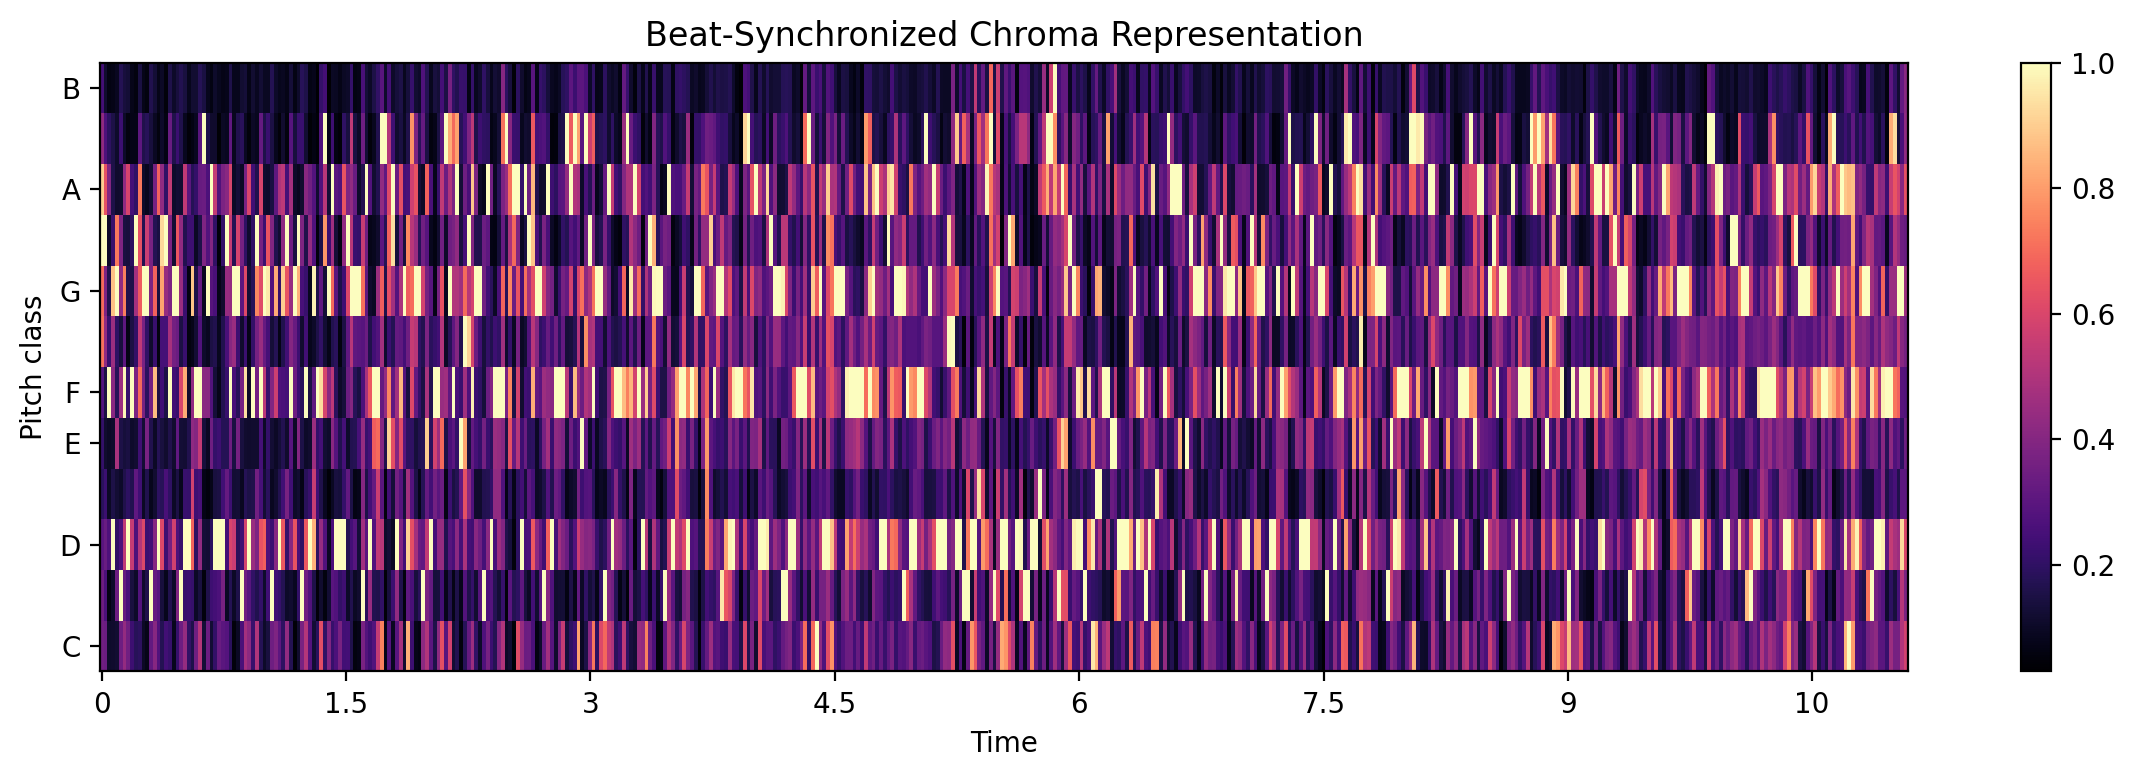

Detected Chords:
['F#min', 'G#', 'Dmin', 'Gmin', 'C', 'C#', 'Dmin', 'Dmin', 'Dmin', 'Fmin', 'Dmin', 'Gmin', 'C', 'C#', 'Dmin', 'Dmin', 'Gmin', 'G#', 'Dmin', 'Gmin', 'C', 'C#', 'Dmin', 'Dmin', 'G', 'F', 'F', 'A#', 'C', 'A', 'D', 'D', 'Dmin', 'G#', 'Dmin', 'Gmin', 'C', 'C#', 'Dmin', 'Dmin', 'Dmin', 'Fmin', 'Dmin', 'Gmin', 'Gmin', 'C#', 'G', 'Dmin', 'Gmin', 'G#', 'Dmin', 'Gmin', 'C#min', 'C#', 'Dmin', 'Dmin', 'G', 'Dmin', 'F', 'A#', 'C', 'Dmin', 'D', 'Dmin', 'D', 'Fmin', 'Gmin', 'Gmin', 'C', 'C#min', 'Dmin', 'Dmin', 'F', 'F', 'Gmin', 'A#', 'E', 'A', 'Dmin', 'F', 'C', 'G#', 'Gmin', 'Gmin', 'Gmin', 'C#min', 'Amin', 'D', 'Dmin', 'Dmin', 'C', 'A#', 'Gmin', 'A#', 'D', 'Emin', 'D#min', 'G#', 'F', 'Gmin', 'Gmin', 'C#min', 'Dmin', 'Dmin', 'Dmin', 'Dmin', 'A#', 'A#', 'A', 'A', 'F', 'G', 'Amin', 'G#', 'Dmin', 'Gmin', 'Gmin', 'C#', 'Dmin', 'Dmin', 'Dmin', 'Dmin', 'F', 'A#', 'Amin', 'A#', 'Gmin', 'Emin', 'D#min', 'Fmin', 'Fmin', 'Gmin', 'C', 'C#min', 'Amin', 'Dmin', 'Dmin', 'Dmin', 'F', 'A#', 'C#', '

In [12]:
import ChordAnalyzer as ca
song = "../src/test_audio/Djavan - Azul (Ao Vivo).wav"
analyzer = ca.ChordAnalyzer(song)

analyzer.analyze_chords()
analyzer.visualize_chroma()
analyzer.print_chords()